# Wideband TOA fitting

Traditional pulsar timing involved measuring only the arrival time of each pulse. But as receivers have covered wider and wider contiguous bandwidths, it became necessary to generate many TOAs for each time interval, covering different subbands. This frequency coverage allowed better handling of changing dispersion measures, but resulted in a large number of TOAs and had certain limitations. A new approach measures the pulse arrival time and the dispersion measure simultaneously from a frequency-resolved data cube. This produces TOAs, each of which has an associated dispersion measure and uncertainty. Working with this data requires different handling from PINT. This notebook demonstrates that.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support

from pint.fitter import Fitter
from pint.models import get_model_and_toas
import pint.config
import pint.logging

# setup logging
pint.logging.setup(level="INFO")

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f02d961df10>

## Set up your inputs

In [2]:
model, toas = get_model_and_toas(
    pint.config.examplefile("J1614-2230_NANOGrav_12yv3.wb.gls.par"),
    pint.config.examplefile("J1614-2230_NANOGrav_12yv3.wb.tim"),
)

The DM and its uncertainty are recorded as flags, `pp_dm` and `pp_dme` on the TOAs that have them, They are not currently available as Columns in the Astropy object. On the other hand, it is not necessary that every observation have a measured DM.

(The name, `pp_dm`, refers to the fact that they are obtained using "phase portraits", like profiles but in one more dimension.)

In [3]:
print(open(toas.filename).readlines()[-1])

guppi_57922_J1614-2230_0006.12y.x.ff 812.60505020 57922.064007172196642   0.419  gbt -pp_dm 34.4877666 -pp_dme 0.0004867 -be GUPPI -ver 20200204 -nchx 55 -tobs 891.204 -f Rcvr_800_GUPPI -gof 1.041 -snr 169.071 -fratio 1.258 -pta NANOGrav -subint 1 -nch 64 -flux 2.43148 -bw 187.435 -chbw 3.125 -fe Rcvr_800 -fluxe 0.01498 -nbin 2048 -proc 12y -tmplt J1614-2230.Rcvr_800.GUPPI.12y.x.avg_port.spl -flux_ref_freq 836.73551



In [4]:
toas.table[-1]

<Row index=274>
index        mjd            mjd_float      error      freq    obs                                                                                                                                                                                                                                                                                  flags                                                                                                                                                                                                                                                                                 delta_pulse_number        tdb                tdbld                       ssb_obs_pos                               ssb_obs_vel                              obs_sun_pos              
                                d            us       MHz                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              km                                      km / s                                     km                  
int64       object           float64      float64   float64   str3                                                                                                                                                                                                                                                                                 object                                                                                                                                                                                                                                                                                     float64             object             float128                      float64[3]                                float64[3]                               float64[3]              
----- ----------------- ----------------- ------- ----------- ---- --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ------------------ ----------------- --------------------- ---------------------------------------- ----------------------------------------- ---------------------------------------
  274 57922.06400717255 57922.06400717254   0.419 812.6050502  gbt {'format': 'Tempo2', 'name': 'guppi_57922_J1614-2230_0006.12y.x.ff', 'pp_dm': '34.4877666', 'pp_dme': '0.0004867', 'be': 'GUPPI', 'ver': '20200204', 'nchx': '55', 'tobs': '891.204', 'f': 'Rcvr_800_GUPPI', 'gof': '1.041', 'snr': '169.071', 'fratio': '1.258', 'pta': 'NANOGrav', 'subint': '1', 'nch': '64', 'flux': '2.43148', 'bw': '187.435', 'chbw': '3.125', 'fe': 'Rcvr_800', 'fluxe': '0.01498', 'nbin': '2048', 'proc': '12y', 'tmplt': 'J1614-2230.Rcvr_800.GUPPI.12y.x.avg_port.spl', 'flux_ref_freq': '836.73551', 'clkcorr': '3.023951845889943e-05'}                0.0 57922.06480791843 57922.064807918432745 -8106233.828294313 .. -60075124.09656769 29.431081448790245 .. -0.7083729035832717 8524988.622096533 .. 60354832

In [5]:
toas.table["flags"][0]

FlagDict({'format': 'Tempo2', 'name': '54724.000006.1.000.000.9y.x.ff', 'pp_dm': '34.4828090', 'pp_dme': '0.0118764', 'be': 'GASP', 'ver': '20200204', 'nchx': '16', 'tobs': '60.078', 'f': 'Rcvr_800_GASP', 'gof': '1.035', 'snr': '35.572', 'fratio': '1.073', 'pta': 'NANOGrav', 'subint': '0', 'nch': '16', 'bw': '60.000', 'chbw': '4.000', 'fe': 'Rcvr_800', 'nbin': '2048', 'proc': '12y', 'tmplt': 'J1614-2230.Rcvr_800.GUPPI.12y.x.avg_port.spl', 'to': '-8.970e-07', 'clkcorr': '2.6166525221999545e-05'})

## Do the fit

As before, but now we need a fitter adapted to wideband TOAs. The function `Fitter.auto()` will examine the model and choose an appropriate one.

In [6]:
fitter = Fitter.auto(toas, model)

In [7]:
fitter.fit_toas()

True

## What is new, compared to narrowband fitting?

### Residual objects combine TOA and time data

In [8]:
type(fitter.resids)

pint.residuals.WidebandTOAResiduals

#### If we look into the resids attribute, it has two independent Residual objects.

In [9]:
fitter.resids.toa, fitter.resids.dm

(<pint.residuals.Residuals at 0x7f02d47e6610>,
 <pint.residuals.WidebandDMResiduals at 0x7f02d653c510>)

#### Each of them can be used independently

* Time residual

Text(0.5, 0, 'MJD')

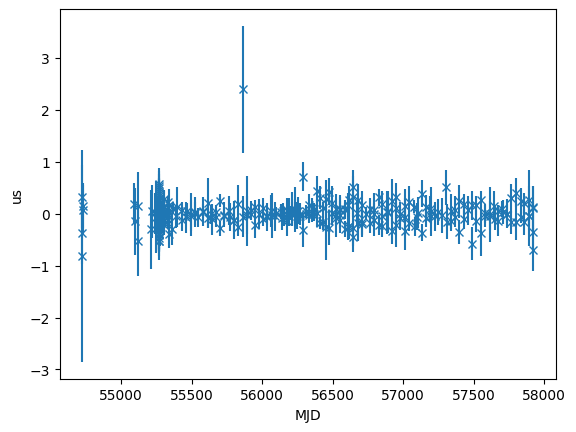

In [10]:
time_resids = fitter.resids.toa.time_resids
plt.errorbar(
    toas.get_mjds().value,
    time_resids.to_value(u.us),
    yerr=toas.get_errors().to_value(u.us),
    fmt="x",
)
plt.ylabel("us")
plt.xlabel("MJD")

In [11]:
# Time RMS
print(fitter.resids.toa.rms_weighted())
print(fitter.resids.toa.chi2)

0.17493106055088772 us
156.75077380469221332


* DM residual

Text(0.5, 0, 'MJD')

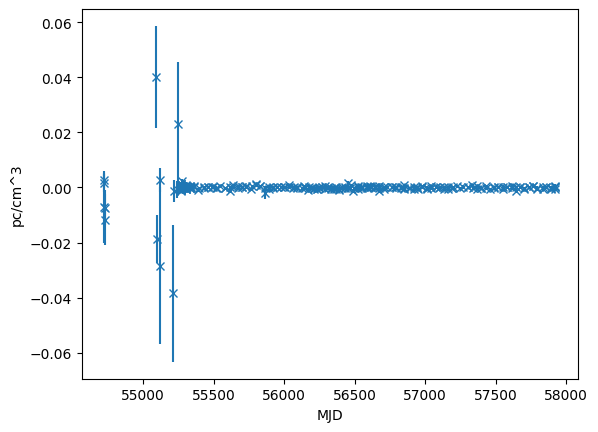

In [12]:
dm_resids = fitter.resids.dm.resids
dm_error = fitter.resids.dm.get_data_error()
plt.errorbar(toas.get_mjds().value, dm_resids.value, yerr=dm_error.value, fmt="x")
plt.ylabel("pc/cm^3")
plt.xlabel("MJD")

In [13]:
# DM RMS
print(fitter.resids.dm.rms_weighted())
print(fitter.resids.dm.chi2)

0.00035817067609101146 pc / cm3
276.42008393172966


#### However, in the combined residuals, one can access rms and chi2 as well

In [14]:
print(fitter.resids.rms_weighted())
print(fitter.resids.chi2)

{'toa': <Quantity 1.74931061e-07 s>, 'dm': <Quantity 0.00035817 pc / cm3>}
433.1708577364218541


#### The initial residuals is also a combined residual object

Text(0.5, 0, 'MJD')

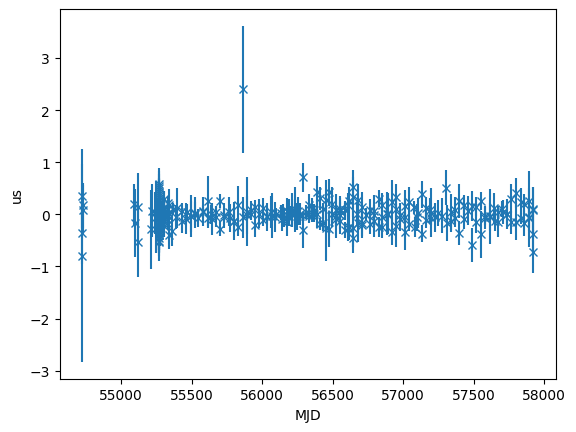

In [15]:
time_resids = fitter.resids_init.toa.time_resids
plt.errorbar(
    toas.get_mjds().value,
    time_resids.to_value(u.us),
    yerr=toas.get_errors().to_value(u.us),
    fmt="x",
)
plt.ylabel("us")
plt.xlabel("MJD")

Text(0.5, 0, 'MJD')

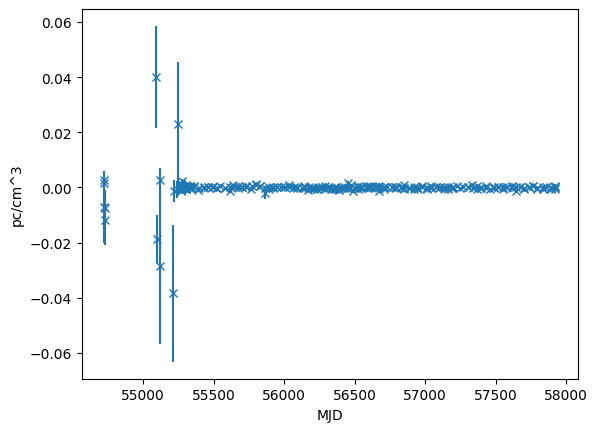

In [16]:
dm_resids = fitter.resids_init.dm.resids
dm_error = fitter.resids_init.dm.get_data_error()
plt.errorbar(toas.get_mjds().value, dm_resids.value, yerr=dm_error.value, fmt="x")
plt.ylabel("pc/cm^3")
plt.xlabel("MJD")

### Matrices

We're now fitting a mixed set of data, so the matrices used in fitting now have different units in different parts, and some care is needed to keep track of which part goes where.

#### Design Matrix are combined

In [17]:
d_matrix, labels, units = fitter.get_designmatrix()

In [18]:
print("Number of TOAs:", toas.ntoas)
print("Number of DM measurments:", len(fitter.resids.dm.dm_data))
print("Number of fit params:", len(fitter.model.free_params))
print("Shape of design matrix:", d_matrix.shape)

Number of TOAs: 275
Number of DM measurments: 275
Number of fit params: 130
Shape of design matrix: (275, 131)


#### Covariance Matrix are combined

In [19]:
# c_matrix = fitter.get_noise_covariancematrix()

In [20]:
# print("Shape of covariance matrix:", c_matrix.shape)

NOTE the matrix are PINTMatrix object right now, here are the difference

If you want to access the matrix data

In [21]:
# print(d_matrix.matrix)

PINT matrix has labels that marks all the element in the matrix. It has the label name, index of range of the matrix, and the unit.

In [22]:
# print("labels for dimension 0:", d_matrix.labels[0])